In [8]:
# help function
from transfer_learning import NeuralNet_sherpa_optimize
from dataset_loader import data_loader, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# New
from transfer_learning import MyDataset
from Statistics_helper import stratified_cluster_sample
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.contrib.metrics.regression import R2Score
import time
from ignite.engine import Events, create_supervised_evaluator
import sherpa
from sklearn.metrics import r2_score


# file name and data path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()
file_name = "data/CrystGrowthDesign_SI.csv"

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
one_filter_columns = ["H2@100 bar/243K (wt%)"]
another_filter_columns = ['5 bar Kr mol/kg']

# load data
data = data_loader(base_path, file_name)
data = data.reset_index(drop=True)
epochs = 1000
batch_size = 128
# parameters
input_size = 5
output_size = 1

# file specifics 
#filename = f"data_epochs-{epochs}_bs-{batch_size}"
trial_parameters={
    "lr" : 0.003014,
    "H_l1" : 257,
    "activate" :  "nn.PReLU"
}
#format data
learning_rate = trial_parameters["lr"]
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
)
df = df[0]
df=df.drop("Cluster",axis=1)
interest = one_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_val, y_df_train, y_df_val = train_test_split(
    df[features], df[interest], test_size=0.1
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)
second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
net_time = []
#create model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)


metrics = {"loss": Loss(criterion), "r_2": R2Score()}

#train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
# train_evaluator.logger = setup_logger("Train Evaluator")
#validation_evaluator = create_supervised_evaluator(
#    model, metrics=metrics, device=device
#)
# validation_evaluator.logger = setup_logger("Val Evaluator")




train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size,shuffle=True)
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)


descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
model.fc1.weight.requires_grad = False
model.fc1.bias.requires_grad = False
model.fc2.weight.requires_grad = False
model.fc2.bias.requires_grad = False
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
)
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, another_filter_columns[0], 5, net_out=True
)
df = df[0]
df=df.drop("Cluster",axis=1)
interest = another_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_val, y_df_train, y_df_val = train_test_split(
    df[features], df[interest], test_size=0.1
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)
second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

interest=another_filter_columns[0]
first = MyDataset(df_train, interest, features)

train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)
second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))


def train_step_1(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()
transfer_trainer = Engine(train_step_1)
metrics = {"loss": Loss(criterion), "r_2": R2Score()}
@transfer_trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    net_time.append(end-start)
    print(e)
transfer_trainer.logger.disabled=True
transfer_trainer.run(train_loader, max_epochs=epochs)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


State:
	iteration: 95000
	epoch: 1000
	epoch_length: 95
	max_epochs: 1000
	output: 0.15988869965076447
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

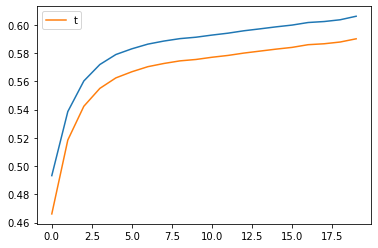

In [17]:
import matplotlib.pyplot as plt
plt.plot(val_r_2)
plt.plot(train_r_2,label="t")
plt.legend()

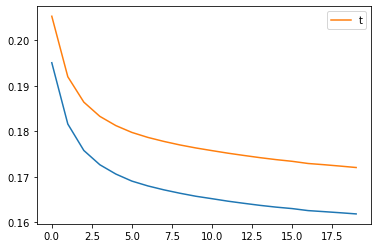

In [15]:
plt.plot(val_loss)
plt.plot(train_loss,label="t")
plt.legend()